# Echo State Network

In [1]:
import numpy as np
from numpy import linalg as LA
import seaborn as sns
import math
from scipy.sparse import random
import librosa
import matplotlib.pyplot as plt
from scipy.spatial import distance

The activation of internal units is updated according to

(1.6) $x(n +1) = f(W^{in} u(n +1) + Wx(n) + W_{back} y(n))$,

where $u(n+1)$ is the externally given input, and $f$ denotes the component-wise application of the individual unit's transfer function, $f$ (also known as activation function, unit output function, or squashing function). We will mostly use the sigmoid function $f = tanh$ but sometimes also consider linear networks with $f = 1$. The output is computed according to

(1.7) $y(n +1) = f_{out} (W_{out} (u(n +1),x(n +1),y(n))$,

where $(u(n+1),x(n+1),y(n))$ denotes the concatenated vector made from input, internal, and output activation vectors. We will use output transfer functions $f_{out} = tanh$ or $f_{out} = 1$; in the latter case we have linear output units.

Transfer function $f = tanh$.

## ESN CODE

In [479]:
def esn_sys(u, alpha=0.01, beta=0.01, SEED=22):
    
    u = (u - np.mean(u)) / (np.max(u) - np.min(u))
    np.random.seed(SEED)
    
    t = u.shape[0] # time len
    N = u.shape[1]

    x = np.zeros((N,))
    X = np.zeros((N,))
    D = np.zeros((N,))
    
    # random weights need to be dampened to avoid chaotic acitivity
    W0_ = random(N, N, density=0.1) # scipy.sparse.random
    W0 = W0_.toarray() # W0_.A
    W1 = np.max(LA.eigvals(W0)) * W0 
    W1[W1!=0] = 2 * W1[W1!=0] - 1 # make non sparse values between [-1,1]
    W = alpha * W1 # scale the matrix
    W = W.real
    
    W_in = np.random.rand(N, N)
    W_in = W_in * beta
    
    x = np.tanh(np.inner(W_in,u[0]) + np.inner(W,x)) # start state at 0
    
    for n in range(t-1):
        x_n = x
        x = np.tanh(np.inner(W_in,u[n+1]) + np.inner(W,x_n))

        X = np.vstack((X,x_n))
        D = np.vstack((D,np.arctanh(u[n+1])))

    X_inv = np.linalg.pinv(X)
    W_out = np.transpose(np.inner(X_inv, np.transpose(D)))


    diff_list = []
    Y = np.zeros((N,))

    for n in range(t-1):
        x_n = x
        x = np.tanh(np.inner(W_in,u[n+1]) + np.transpose(np.inner(W,x_n)))

        y = np.tanh(np.inner(W_out,x))
        Y = np.vstack((Y,y))

        sq_diff = np.square(y-u[n+1])
        diff_list.append(np.mean(sq_diff))

    return diff_list, X

## TESTS

### I) Predict output from $t-\delta$ away

In [7]:
# compare y and d on time axis or each on 1 axis
# sum of all (at each t): diff squared at each time step t
# W_out: x*u[n-1]
# predict output only if I'm t-delta away
# W_out: x*u[n-delta]

### II) Observe network state for common part of 2 different inputs

In [226]:
def make_stim(N=10, init_state = 0, incr_st = 0.0, incr_mid = +0.005, incr_end = 0.0): 

    stim = np.zeros((N,)) + init_state
    add = stim + incr_st
    stim = np.vstack((stim,add))

    for n in range(1,N*10):
        add = stim[-1] + incr_st
        stim = np.vstack((stim,add))

    for n in range(1,N*10):
        add = stim[-1] + incr_mid
        stim = np.vstack((stim,add))

    for n in range(0,N*10):
        add = stim[-1] + incr_end
        stim = np.vstack((stim,add))
    
    return stim

In [374]:
from scipy.spatial import distance

def compare_data(s1, s2):
    N = s1.shape[0]
    # euclidian distance between s1 and s2
    result = []
    for n in range(N):
        result.append(distance.euclidean(s1[n],s2[n]))
    return result

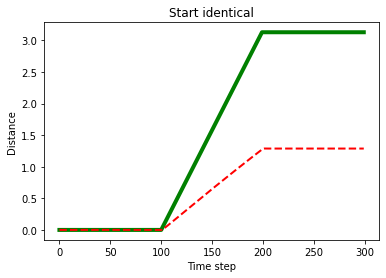

In [375]:
start_ident_neg = make_stim(N=10, init_state = 0, incr_st = 0.0, incr_mid = -0.005, incr_end = 0.0)
start_ident_pos = make_stim(N=10, init_state = 0, incr_st = 0.0, incr_mid = +0.005, incr_end = 0.0)

st_neg_esn = esn_sys(start_ident_neg)[1]
st_pos_esn = esn_sys(start_ident_pos)[1]

stim_st = compare_data(start_ident_neg, start_ident_pos)
sys_st = compare_data(st_neg_esn, st_pos_esn)

plt.title("Start identical") 
plt.xlabel("Time step") 
plt.ylabel("Distance")
plt.plot(stim_st, color ="green", linewidth=4) 
plt.plot(sys_st, color ="red", linewidth=2, linestyle='dashed') 
plt.show()   

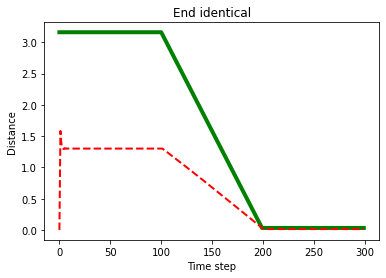

In [376]:
end_ident_neg = make_stim(N=10, init_state = - 0.5, incr_st = 0.0, incr_mid = +0.005, incr_end = 0.0)
end_ident_pos = make_stim(N=10, init_state = 0.5 , incr_st = 0.0, incr_mid = -0.005, incr_end = 0.0)
end_neg_esn = esn_sys(end_ident_neg)[1]
end_pos_esn = esn_sys(end_ident_pos)[1]

stim_end = compare_data(end_ident_neg, end_ident_pos)
sys_end = compare_data(end_neg_esn, end_pos_esn)

plt.title("End identical") 
plt.xlabel("Time step") 
plt.ylabel("Distance") 
plt.plot(stim_end, color ="green", linewidth=4) 
plt.plot(sys_end, color ="red", linewidth=2, linestyle='dashed') 
plt.show() 

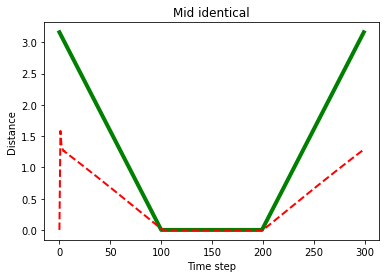

In [377]:
mid_ident_neg = make_stim(N=10, init_state = - 0.5, incr_st = 0.005, incr_mid = +0.0, incr_end = 0.005)
mid_ident_pos = make_stim(N=10, init_state = 0.5 , incr_st = -0.005, incr_mid = +0.0, incr_end = -0.005)
mid_neg_esn = esn_sys(mid_ident_neg)[1]
mid_pos_esn = esn_sys(mid_ident_pos)[1]

stim_mid = compare_data(mid_ident_neg, mid_ident_pos)
sys_mid = compare_data(mid_neg_esn, mid_pos_esn)

plt.title("Mid identical") 
plt.xlabel("Time step") 
plt.ylabel("Distance") 
plt.plot(stim_mid, color ="green", linewidth=4) 
plt.plot(sys_mid, color ="red", linewidth=2, linestyle='dashed') 
plt.show() 

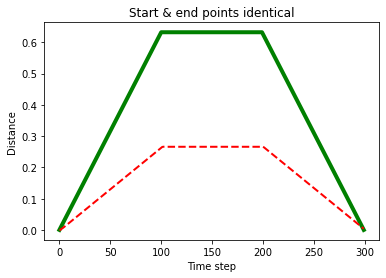

In [340]:
st_end_ident_neg = make_stim(N=10, init_state = 0, incr_st = 0.001, incr_mid = +0.0, incr_end = - 0.001)
st_end_ident_pos = make_stim(N=10, init_state = 0 , incr_st = - 0.001, incr_mid = +0.0, incr_end = + 0.001)
st_end_neg_esn = esn_sys(st_end_ident_neg)[1]
st_end_pos_esn = esn_sys(st_end_ident_pos)[1]

stim_st_end = compare_data(st_end_ident_neg, st_end_ident_pos)
sys_st_end = compare_data(st_end_neg_esn, st_end_pos_esn)

plt.title("Start & end points identical") 
plt.xlabel("Time step") 
plt.ylabel("Distance") 
plt.plot(stim_st_end, color ="green", linewidth=4) 
plt.plot(sys_st_end, color ="red", linewidth=2, linestyle='dashed') 
plt.show() 

## NOISE (SPECTROGRAMS)

Construct the noise stimuli and check how they sound.

In [386]:
import IPython.display as ipd
noise1 = np.random.normal(-1, 0.9, size=100000)
noise2 = np.random.normal(1, 0.5, size=100000)
noise3 = np.random.normal(0, 0.1, size=100000)
noise = np.concatenate((noise1, noise2, noise3))
ipd.Audio(noise, rate=16000) # load a local WAV file

In [387]:
import soundfile as sf
sf.write('test.wav', noise, 16000)

[Text(0.5, 1.0, 'Mel-frequency spectrogram')]

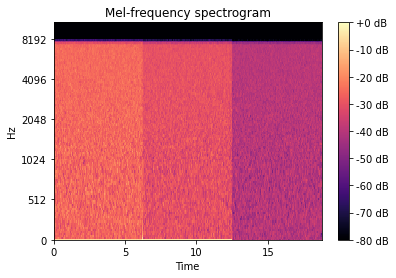

In [388]:
import librosa.display
# sig, rate = librosa.load("/Users/nika/Documents/hopfield_hash/wavs/452c0a0b.wav")
sig, rate = librosa.load("test.wav")
S = librosa.feature.melspectrogram(y=sig, sr=rate)
fig, ax = plt.subplots()
S_dB = librosa.power_to_db(S, ref=np.max)
img = librosa.display.specshow(S_dB, x_axis='time',y_axis='mel', sr=rate, ax=ax)
fig.colorbar(img, ax=ax, format='%+2.0f dB')
ax.set(title='Mel-frequency spectrogram')

In [508]:
noise1 = np.random.normal(-1, 0.9, size=100000)

noise2 = np.random.normal(1, 0.5, size=100000)

noise3 = np.random.normal(0, 0.3, size=100000)

noise4 = np.random.normal(-0.5, 0.7, size=100000)

noise5 = np.random.normal(0.5, 0.1, size=100000)

In [509]:
start1 = np.concatenate((noise5, noise2, noise3))
start2 = np.concatenate((noise5, noise4, noise1))

end1 = np.concatenate((noise1, noise1, noise5))
end2 = np.concatenate((noise3, noise5, noise5))

mid1 = np.concatenate((noise4, noise5, noise3))
mid2 = np.concatenate((noise2, noise5, noise1))

In [510]:
rate = 16000

start_id1 = np.transpose(librosa.feature.melspectrogram(y=start1, sr=rate))
start_id2 = np.transpose(librosa.feature.melspectrogram(y=start2, sr=rate))

end_id1 = np.transpose(librosa.feature.melspectrogram(y=end1, sr=rate))
end_id2 = np.transpose(librosa.feature.melspectrogram(y=end2, sr=rate))

mid_id1 = np.transpose(librosa.feature.melspectrogram(y=mid1, sr=rate))
mid_id2 = np.transpose(librosa.feature.melspectrogram(y=mid2, sr=rate))

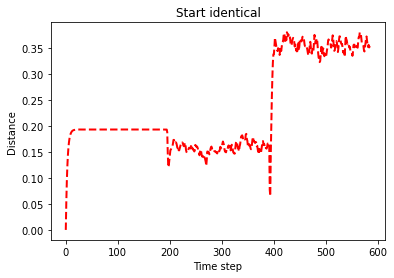

In [511]:
start_stim = compare_data(start_id1, start_id2)

start_esn1 = esn_sys(start_id1)[1]
start_esn2 = esn_sys(start_id2)[1]

start_sys = compare_data(start_esn1, start_esn2)

plt.title("Start identical") 
plt.xlabel("Time step") 
plt.ylabel("Distance") 
# plt.plot(start_stim, color ="green", linewidth=2) 
plt.plot(start_sys, color ="red", linewidth=2, linestyle='dashed') 
plt.show() 

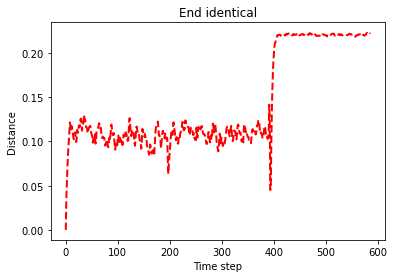

In [512]:
end_stim = compare_data(end_id1, end_id2)

end_esn1 = esn_sys(end_id1)[1]
end_esn2 = esn_sys(end_id2)[1]

end_sys = compare_data(end_esn1, end_esn2)

plt.title("End identical") 
plt.xlabel("Time step") 
plt.ylabel("Distance") 
# plt.plot(end_stim, color ="green", linewidth=2) 
plt.plot(end_sys, color ="red", linewidth=2, linestyle='dashed') 
plt.show() 

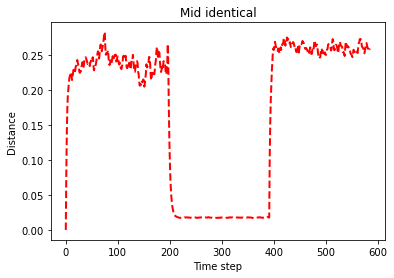

In [513]:
mid_stim = compare_data(mid_id1, mid_id2)

mid_esn1 = esn_sys(mid_id1, alpha = 0.01)[1]
mid_esn2 = esn_sys(mid_id2, alpha = 0.01)[1]

mid_sys = compare_data(mid_esn1, mid_esn2)

plt.title("Mid identical") 
plt.xlabel("Time step") 
plt.ylabel("Distance") 
# plt.plot(mid_stim, color ="green", linewidth=2) 
plt.plot(mid_sys, color ="red", linewidth=2, linestyle='dashed') 
plt.show() 

## NOISE (VECTORS)

In [457]:
def make_noise(mean, var, size=128, r=100000):
    noise = np.random.normal(mean, var, size=size)
    for i in range(r):
        noise_v = np.random.normal(mean, var, size=size)
        noise = np.vstack((noise, noise_v))
    return noise

In [459]:
noise1 = make_noise(-1, 0.9)

noise2 = make_noise(1, 0.5)

noise3 = make_noise(0, 0.3)

noise4 = make_noise(-0.5, 0.7)

noise5 = make_noise(0.5, 0.1, size=128)

In [460]:
start1 = np.concatenate((noise5, noise2, noise3))
start2 = np.concatenate((noise5, noise4, noise1))

end1 = np.concatenate((noise1, noise1, noise5))
end2 = np.concatenate((noise3, noise5, noise5))

mid1 = np.concatenate((noise4, noise5, noise3))
mid2 = np.concatenate((noise2, noise5, noise1))

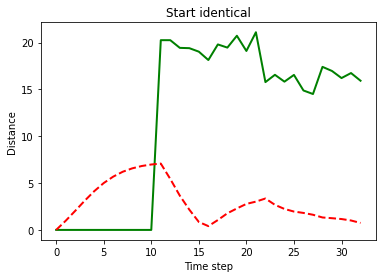

In [496]:
start_stim = compare_data(start1, start2)

start_esn1 = esn_sys(start1, alpha = 0.015)[1]
start_esn2 = esn_sys(start2, alpha = 0.015)[1]

start_sys = compare_data(start_esn1, start_esn2)

plt.title("Start identical") 
plt.xlabel("Time step") 
plt.ylabel("Distance") 
plt.plot(start_stim, color ="green", linewidth=2) 
plt.plot(start_sys, color ="red", linewidth=2, linestyle='dashed') 
plt.show() 

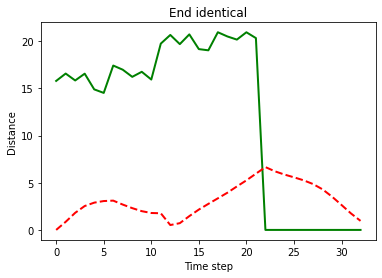

In [495]:
end_stim = compare_data(end1, end2)

end_esn1 = esn_sys(end1, alpha = 0.015)[1]
end_esn2 = esn_sys(end2, alpha = 0.015)[1]

end_sys = compare_data(end_esn1, end_esn2)

plt.title("End identical") 
plt.xlabel("Time step") 
plt.ylabel("Distance") 
plt.plot(end_stim, color ="green", linewidth=2) 
plt.plot(end_sys, color ="red", linewidth=2, linestyle='dashed') 
plt.show() 

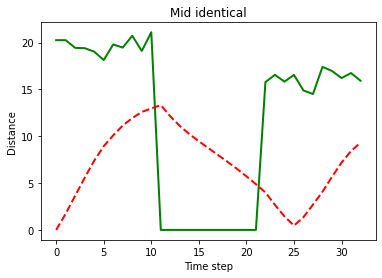

In [494]:
mid_stim = compare_data(mid1, mid2)

mid_esn1 = esn_sys(mid1, alpha = 0.015)[1]
mid_esn2 = esn_sys(mid2, alpha = 0.015)[1]

mid_sys = compare_data(mid_esn1, mid_esn2)

plt.title("Mid identical") 
plt.xlabel("Time step") 
plt.ylabel("Distance") 
plt.plot(mid_stim, color ="green", linewidth=2) 
plt.plot(mid_sys, color ="red", linewidth=2, linestyle='dashed') 
plt.show() 